## Сегментация изображений клеток

Вам предстоит обучить модель сегментировать изображения с дрожжевыми клетками и микроструктурами (см. [06_segmentation.ipynb](../workshops/06_segmentation.ipynb)), по пути поэкспериментировав с разными архитектурами и функцими ошибки.

### Задание 1 (2 балл). Метрики сегментации
Перед экспериментами нужно определиться с метриками. Выберите 3-5 метрик, по которым вы будете оценивать качество модели. В этом задании объясните свой выбор и найдите нужные метрики в `torchvision` (а если их нет - реализуйте самостоятельно, здесь вам может помочь [05_lightning_etc.ipynb](../workshops/05_lightning_etc.ipynb))

In [30]:
%%capture
!pip install lightning
!pip install --upgrade torchmetrics

from pathlib import Path
import random
import os

import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd

from lightning.pytorch.loggers import CSVLogger

In [4]:
%%capture
! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

In [5]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
train_dir = dataset_dir / "train"

In [6]:
import torchmetrics.classification

def create_classification_metrics(
    num_classes: int, prefix: str
) -> torchmetrics.MetricCollection:
    return torchmetrics.MetricCollection(
        [
            torchmetrics.Accuracy(task="multiclass", num_classes=num_classes),
            torchmetrics.classification.MulticlassAUROC(
                num_classes=num_classes, average="macro"),
            torchmetrics.classification.MulticlassF1Score(num_classes=num_classes),
            torchmetrics.JaccardIndex(num_classes=num_classes, task='multiclass')
        ],
        prefix=prefix,
    )

Accuracy позволит оценить долю пикселей, для которых классы предсказаны правильно. С помощью MulticlassAUROC мы измерим способность модели различать классы. MulticlassF1Score сочетает в себе метрики presicion и recall, позволяет судить о том, как часто модель ошибается, учитывая при этом false positive и false negative метки. JaccardIndex - отношение пересечения между предсказанными и истинными пикселями к объединению этих наборов.

### Задание 2 (4 балла). Обучение модели
Возьмите модель и датасеты из практики по сегментации и запустите обучение.

Указания:
- Каждую эпоху сохраняйте значения ошибки и выбранные в задании 1 метрики как для обучающего датасета (`train`), так и для валидационного (`val`).
- Каждую эпоху сохраняйте примеры работы модели на 8 случайных изображениях из валидационного датасета (одной картинкой, как в практике).
- После окончания обучения выведите графики значений ваших метрик и примеры предсказаний (достаточно 4-5 изображений: для первой эпохи, 2-3 в середине обучения и ндля последней эпохи).
- Можете использовать `lightning` (вместо `lightning.pytorch.loggers.TensorBoardLogger` можно использовать `lightning.pytorch.loggers.CSVLogger`, а сохранение изображений можете реализовать как `lightning.pytorch.Callback`), а можете всё написать вручную.

In [7]:
class YeastDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        # нужно вернуть пару
        # тензор изображения C x W x H
        # словарь с ключами boxes, masks, labels
        image_path = self.items[index]
        image = torch.load(image_path, weights_only=True).unsqueeze(
            0
        )  # (W, H) -> (1, W, H)
        classes = (
            torch.load(
                self.subset_dir / "classes" / image_path.parts[-1], weights_only=True
            )
            + 1
        )  # 0 класс - фон
        masks = torch.load(
            self.subset_dir / "instances" / image_path.parts[-1], weights_only=True
        )
        boxes = torch.load(
            self.subset_dir / "bounding_boxes" / image_path.parts[-1], weights_only=True
        )
        return image, dict(
            boxes=boxes,
            labels=classes,
            masks=masks,
        )

    def __len__(self) -> int:
        return len(self.items)

In [8]:
class YeastSemanticSegmDataset(YeastDataset):
    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image, annotation = super().__getitem__(index)
        # нужно сформировать маску: тензор размера W x H, где для каждого пиксела указан класс
        mask = (
            (annotation["masks"] * annotation["labels"].view(-1, 1, 1)).sum(dim=0)
        ).long()

        return image, mask

In [9]:
train_dataset = YeastSemanticSegmDataset(train_dir)

In [10]:
from typing import Any, Callable, Type

from lightning.pytorch import Callback
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS, STEP_OUTPUT
from torch.utils.data import DataLoader

_collate_fn_t = Callable[[list[tuple[Tensor, Any]]], Any]


class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        datadir: Path,
        dataset_class: Type[Dataset],
        batch_size: int,
        train_subdir: str = "train",
        val_subdir: str = "val",
        test_subdir: str = "test",
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataset_class = dataset_class
        self.train_dir = datadir / train_subdir
        self.val_dir = datadir / val_subdir
        self.test_dir = datadir / test_subdir

    @property
    def collate_fn(self) -> _collate_fn_t | None:
        if self.dataset_class == YeastSemanticSegmDataset:
            return None
        else:
            return lambda batch: tuple(zip(*batch))

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = self.dataset_class(self.val_dir)
        if stage == "fit":
            self.train_dataset = self.dataset_class(self.train_dir)
        elif stage == "test":
            self.test_dataset = self.dataset_class(self.test_dir)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

In [11]:
datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)

In [12]:
class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float, loss_func: Callable=F.cross_entropy) -> None:
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.model = model
        self.learning_rate = learning_rate
        self.loss_func = loss_func
        self.train_metrics = create_classification_metrics(
            num_classes=3, prefix="train_"
        )
        self.val_metrics = create_classification_metrics(num_classes=3, prefix="val_")

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_func(y_hat, y)

        # loss теперь сохраняем только раз в эпоху
        self.log("train_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.train_metrics.update(y_hat, y)
        self.log_dict(self.train_metrics, on_step=False, on_epoch=True)

        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_func(y_hat, y)

        self.log("val_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.val_metrics.update(y_hat, y)
        self.log_dict(self.val_metrics, on_step=False, on_epoch=True)
        # на этот раз вернём предсказания - будем их потом использовать, чтобы отрисовывать confusion matrix

        return {
            "loss": loss,
            "preds": y_hat,
        }

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # давайте кроме оптимизатора создадим ещё расписание для шага оптимизации
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[5, 10, 15]
            ),
        }

In [22]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.double_conv(x)

In [23]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.maxpool_conv(x)

In [24]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(
        self, in_channels: int, out_channels: int, bilinear: bool = True
    ) -> None:
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_prev: Tensor, x_skip: Tensor) -> Tensor:
        x_prev = self.up(x_prev)
        # input is BCHW
        d_height = x_skip.size()[2] - x_prev.size()[2]
        d_width = x_skip.size()[3] - x_prev.size()[3]

        x_prev = F.pad(
            x_prev,
            [
                d_width // 2,
                d_width - d_width // 2,
                d_height // 2,
                d_height - d_height // 2,
            ],
        )
        x = torch.cat([x_skip, x_prev], dim=1)
        return self.conv(x)

In [25]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        # создаём список для хранения промежуточных активаций
        xs = []
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits

In [13]:
class VisualizationCallback(Callback):
    def __init__(self, pictures_dir: str):
        super().__init__()
        self.saved_images = {}
        self.pictures_dir = pictures_dir

    def on_validation_epoch_end(self, trainer, pl_module):
        indices = random.sample(range(len(trainer.datamodule.val_dataset)), 8)
        images = torch.stack([trainer.datamodule.val_dataset[i][0] for i in indices]).to(torch.device('cuda'))
        with torch.no_grad():
            predictions = pl_module.model.forward(images)
        original_images_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
        masks_grid = torchvision.utils.make_grid(
          torch.nn.functional.one_hot(predictions.argmax(dim=1), 3).permute(0, 3, 1, 2)[:, 1:]
          > 0,
          nrow=4,
        )

        predictions_grid = torchvision.utils.draw_segmentation_masks(
          original_images_grid,
          masks=masks_grid,
          alpha=0.4,
          colors=["red", "green"],
        )

        plt.figure(figsize=(12, 5))
        plt.axis("off")

        os.makedirs(self.pictures_dir, exist_ok=True)
        epoch = trainer.current_epoch

        plt.imshow(transforms.ToPILImage()(predictions_grid))
        plt.savefig(f'{self.pictures_dir}/visualization_epoch_{epoch}.png')
        plt.close()

        self.saved_images[epoch] = f'{self.pictures_dir}/visualization_epoch_{epoch}.png'


In [14]:
from PIL import Image

def graph(file: str):
    data = pd.read_csv(file)

    plt.figure(figsize=(7, 5))
    for metric in lit_module.train_metrics:
        plt.plot(data['epoch'].iloc[1::2].reset_index(drop=True),
                data[metric].dropna(), marker='o', label=metric, linestyle='-')
    plt.title('train metrics over epochs')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    for metric in lit_module.val_metrics:
        plt.plot(data['epoch'].iloc[::2].reset_index(drop=True),
                data[metric].dropna(), marker='o', label=metric, linestyle='-')
    plt.title('validation metrics over epochs')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(data['epoch'].iloc[1::2].reset_index(drop=True),
          data['train_loss'].dropna(), marker='o', label='train_loss', linestyle='-')
    plt.plot(data['epoch'].iloc[::2].reset_index(drop=True),
          data['val_loss'].dropna(), marker='o', label='val_loss', linestyle='-')
    plt.title('train and validation loss over epochs')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

def epoch_pics(callback):
    images = callback.saved_images
    n = len(images)
    epochs = [0, n//2 - 1, n//2 + 1, n - 1]
    for e in epochs:
        img = Image.open(images[e])
        plt.imshow(img)
        plt.title(f'epoch = {e}')
        plt.axis('off')
        plt.show()


In [17]:
callback = VisualizationCallback(pictures_dir='epoch_pics_task2')
torch.manual_seed(42)
model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    limit_train_batches=None,
    limit_val_batches=None,
    logger=CSVLogger(save_dir=".", name="model_logs_task2", version=0),
    callbacks=[callback]
)
lit_module = Lit(
    model=model,
    learning_rate=0.01,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

trainer.validate(model=lit_module, dataloaders=datamodule.val_dataloader())

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_MulticlassAUROC     │     0.9957966804504395     │
│   val_MulticlassAccuracy   │     0.9633433818817139     │
│   val_MulticlassF1Score    │     0.937743067741394      │
│ val_MulticlassJaccardIndex │     0.8851268291473389     │
│          val_loss          │    0.09111333638429642     │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.09111333638429642,
  'val_MulticlassAccuracy': 0.9633433818817139,
  'val_MulticlassAUROC': 0.9957966804504395,
  'val_MulticlassF1Score': 0.937743067741394,
  'val_MulticlassJaccardIndex': 0.8851268291473389}]

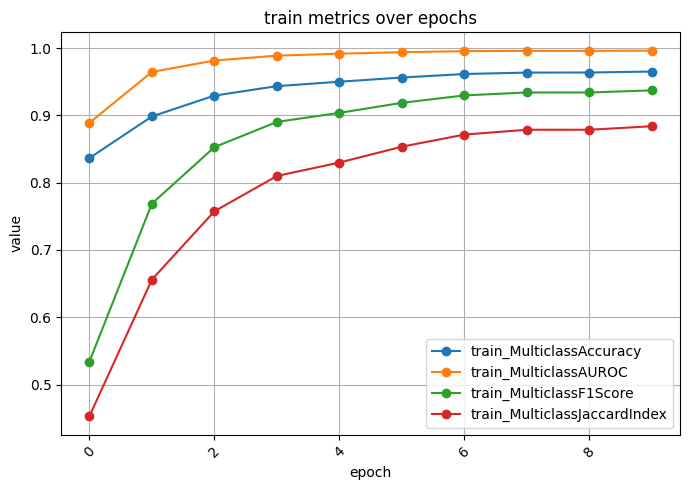

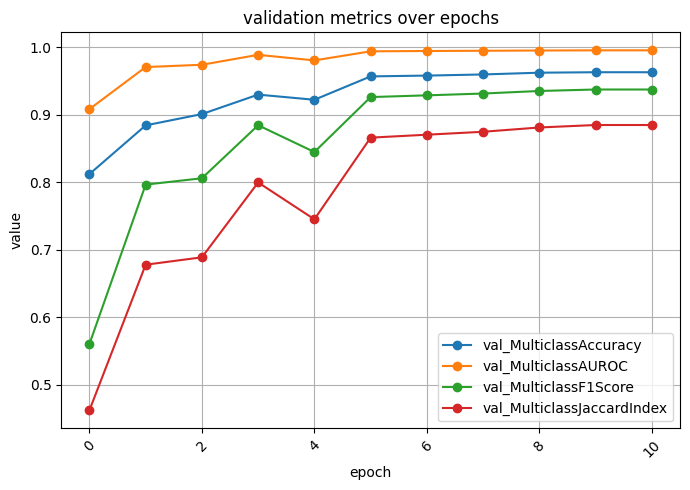

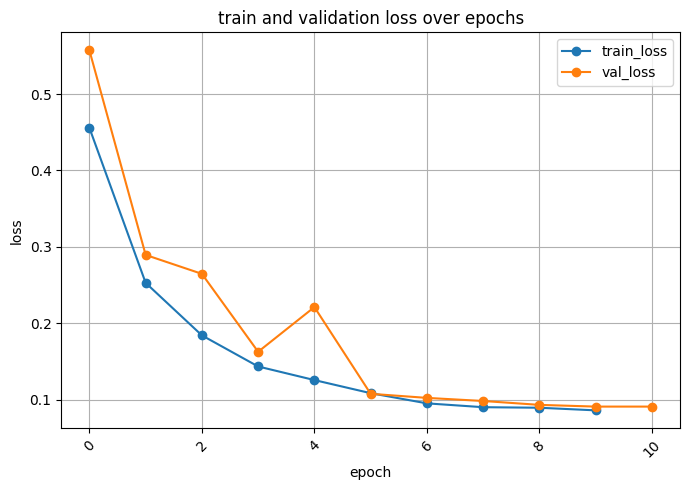

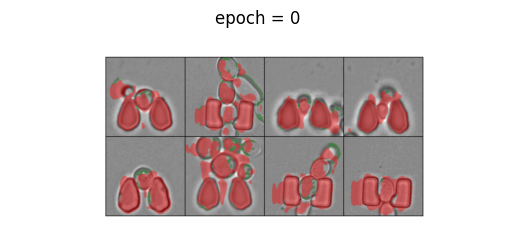

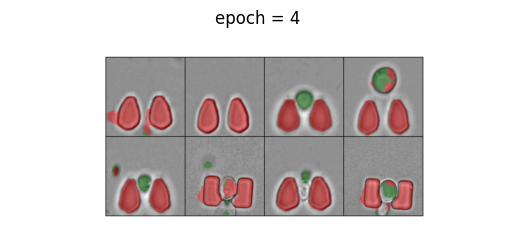

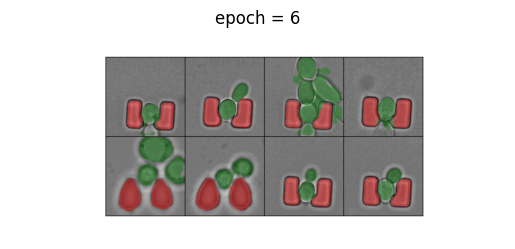

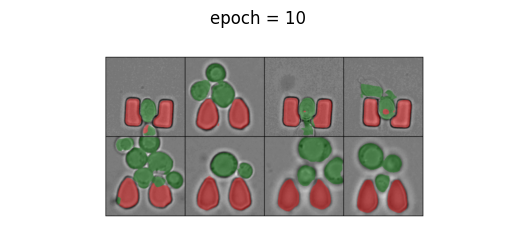

In [18]:
graph('model_logs_task2/version_0/metrics.csv')
epoch_pics(callback)

### Задание 3 (3 балла). Выбор другой функции ошибки

Полезная ссылка:
https://www.jeremyjordan.me/semantic-segmentation/#loss

Повторите эксперимент из задания 2, но попробуйте модифицировать функцию ошибки:
- (2 балла) учитывайте пиксели на границе объектов с большим весом, как предлагается в статье [U-Net](https://arxiv.org/abs/1505.04597)
- (1 балл) используйте soft Dice loss

Опишите свои наблюдения, что изменилось? Обратите внимание на скорость обучения, визуальные артефакты предсказаний, динамику метрик.


In [15]:
def loss_weights(y_hat, y):
    loss = F.cross_entropy(y_hat, y, reduction='none')
    weight = 2
    edges1, edges2 = torch.ByteTensor(y.shape).zero_(), torch.ByteTensor(y.shape).zero_()
    for b in range(y.shape[0]):
        for c in range(1, y.shape[1]):
            edges1[b, c, :] = y[b, c, :] != y[b, c - 1, :]
            edges2[b, :, c] = y[b, :, c] != y[b, :, c - 1]
    edges = edges1 + edges2
    edges = edges.to(y_hat.device).float()
    loss = torch.mean(loss * (1.0 + edges * weight))
    return loss


# def soft_dice_loss(y_hat, y):
#     smooth = 1e-6
#     N, H, W = y.size()
#     one_hot = torch.zeros(N, y_hat.size(1), H, W, device=y.device)
#     y = y.long()
#     y_one_hot = one_hot.scatter_(1, y.unsqueeze(1), 1)
#     y_hat_flat = y_hat.view(y_hat.size(0), y_hat.size(1), -1)  # (N, C, H*W)
#     y_flat = y_one_hot.view(y_one_hot.size(0), y_one_hot.size(1), -1)  # (N, C, H*W)
#     intersection = (y_hat_flat * y_flat).sum(dim=2)  # (N, C)
#     total = y_hat_flat.sum(dim=2) + y_flat.sum(dim=2)  # (N, C)
#     dice_score = (2. * intersection + smooth) / (total + smooth)  # (N, C)
#     loss = torch.mean(1 - dice_score)  # (N, C)
#     return loss


#   shows these results:
#   [{'val_loss': 0.10950174927711487,
#     'val_MulticlassAccuracy': 0.9645189642906189,
#     'val_MulticlassAUROC': 0.99639892578125,
#     'val_MulticlassF1Score': 0.9400945901870728}]





def soft_dice_loss(y_hat, y, smooth=1e-6):
    num_classes = y_hat.size(1)
    y_hat = F.softmax(y_hat, dim=1)
    y_one_hot = F.one_hot(y, num_classes=num_classes).permute(0, 3, 1, 2).float()
    dice_loss = 0
    for class_index in range(num_classes):
        y_hat_class = y_hat[:, class_index, :, :]
        y_class = y_one_hot[:, class_index, :, :]

        numerator = (y_hat_class * y_class).sum()
        denominator = y_hat_class.sum() + y_class.sum()

        dice_score = (2.0 * numerator + smooth) / (denominator + smooth)
        dice_loss += 1 - dice_score
    return dice_loss / num_classes

# shows these results:
# [{'val_loss': 0.06820887327194214,
# 'val_MulticlassAccuracy': 0.9603747725486755,
# 'val_MulticlassAUROC': 0.9829502105712891,
# 'val_MulticlassF1Score': 0.9329429864883423}]




In [20]:
# from lightning.pytorch.loggers import CSVLogger
# class MyCustomCallback_new(Callback):
#   def __init__(self):
#         super().__init__()
#         self.saved_images = {}

#   def on_validation_epoch_end(self, trainer, pl_module):
#       indices = random.sample(range(len(datamodule.val_dataset)), 8)
#       images = torch.stack([datamodule.val_dataset[i][0] for i in indices]).to(torch.device('cuda')) # use not with cpu
#       # images = torch.stack([datamodule.val_dataset[i][0] for i in indices]) # use with cpu

#       with torch.no_grad():
#         predictions = pl_module.model.forward(images)
#       original_images_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
#       masks_grid = torchvision.utils.make_grid(
#           torch.nn.functional.one_hot(predictions.argmax(dim=1), 3).permute(0, 3, 1, 2)[:, 1:]
#           > 0,
#           nrow=4,
#       )

#       predictions_grid = torchvision.utils.draw_segmentation_masks(
#           original_images_grid,
#           masks=masks_grid,
#           alpha=0.4,
#           colors=["red", "green"],
#       )

#       plt.figure(figsize=(12, 5))
#       plt.axis("off")

#       os.makedirs('epoch_pics_3', exist_ok=True)
#       epoch = trainer.current_epoch

#       plt.imshow(transforms.ToPILImage()(predictions_grid))
#       plt.savefig(f'epoch_pics_3/visualization_epoch_{epoch}.png')
#       plt.close()

#       self.saved_images[epoch] = f'epoch_pics_3/visualization_epoch_{epoch}.png'


In [21]:
callback = VisualizationCallback(pictures_dir='epoch_pics_task3_1')
model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    limit_train_batches=None,
    limit_val_batches=None,
    logger=CSVLogger(save_dir=".", name="model_logs_task3_1", version=0),
    callbacks=[callback]
)
lit_module = Lit(
    model=model,
    learning_rate=0.01,
    loss_func=loss_weights
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

trainer.validate(model=lit_module, dataloaders=datamodule.val_dataloader())

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_MulticlassAUROC     │     0.9958170652389526     │
│   val_MulticlassAccuracy   │     0.9625763893127441     │
│   val_MulticlassF1Score    │     0.9357904195785522     │
│ val_MulticlassJaccardIndex │     0.8818082809448242     │
│          val_loss          │    0.11792580038309097     │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.11792580038309097,
  'val_MulticlassAccuracy': 0.9625763893127441,
  'val_MulticlassAUROC': 0.9958170652389526,
  'val_MulticlassF1Score': 0.9357904195785522,
  'val_MulticlassJaccardIndex': 0.8818082809448242}]

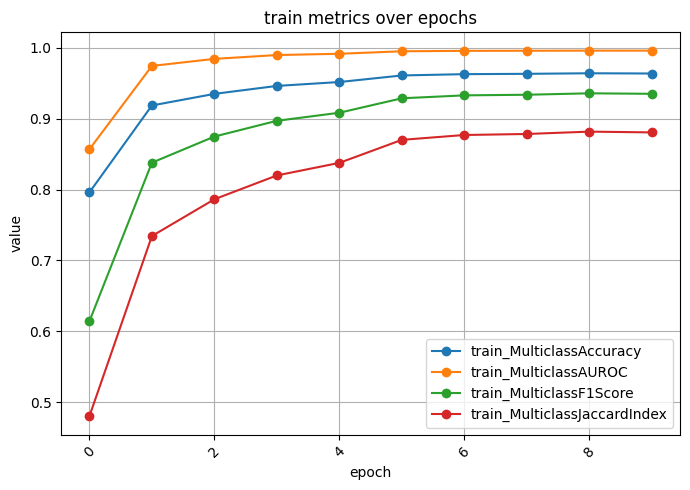

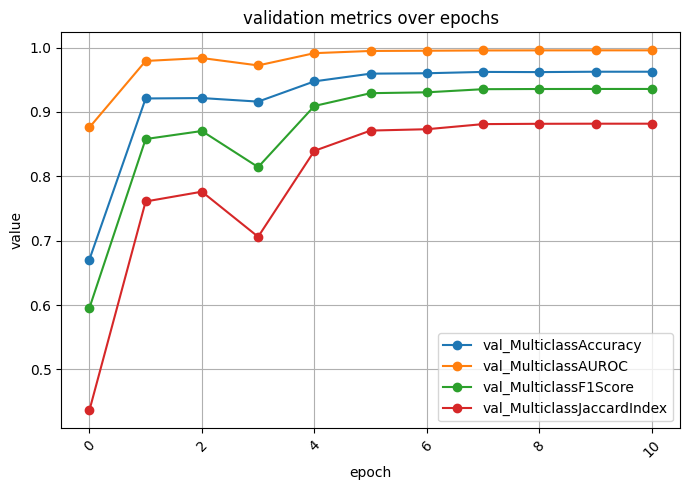

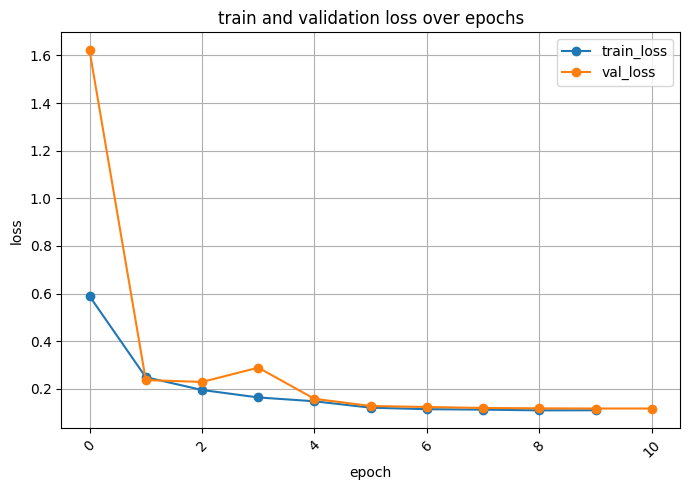

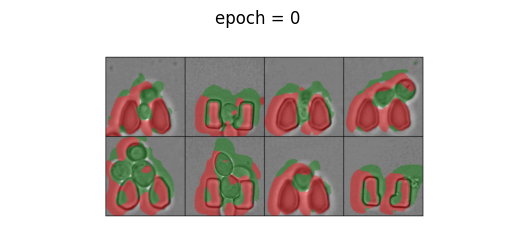

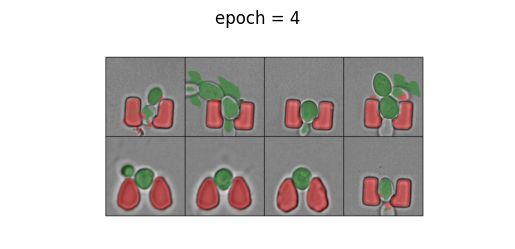

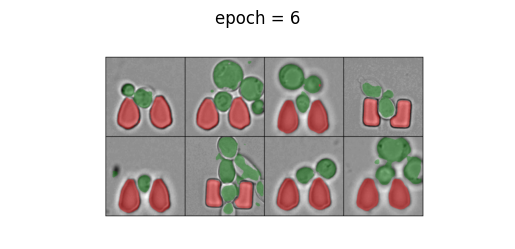

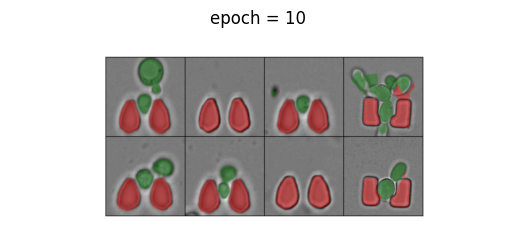

In [22]:
graph('model_logs_task3_1/version_0/metrics.csv')
epoch_pics(callback)

In [23]:
callback = VisualizationCallback(pictures_dir='epoch_pics_task3_2')
model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    limit_train_batches=None,
    limit_val_batches=None,
    logger=CSVLogger(save_dir=".", name="model_logs_task3_2", version=0),
    callbacks=[callback]
)
lit_module = Lit(
    model=model,
    learning_rate=0.01,
    loss_func=soft_dice_loss
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

trainer.validate(model=lit_module, dataloaders=datamodule.val_dataloader())

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_MulticlassAUROC     │     0.9771382808685303     │
│   val_MulticlassAccuracy   │     0.9652280211448669     │
│   val_MulticlassF1Score    │     0.9412237405776978     │
│ val_MulticlassJaccardIndex │     0.8909153938293457     │
│          val_loss          │     0.0597219355404377     │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.0597219355404377,
  'val_MulticlassAccuracy': 0.9652280211448669,
  'val_MulticlassAUROC': 0.9771382808685303,
  'val_MulticlassF1Score': 0.9412237405776978,
  'val_MulticlassJaccardIndex': 0.8909153938293457}]

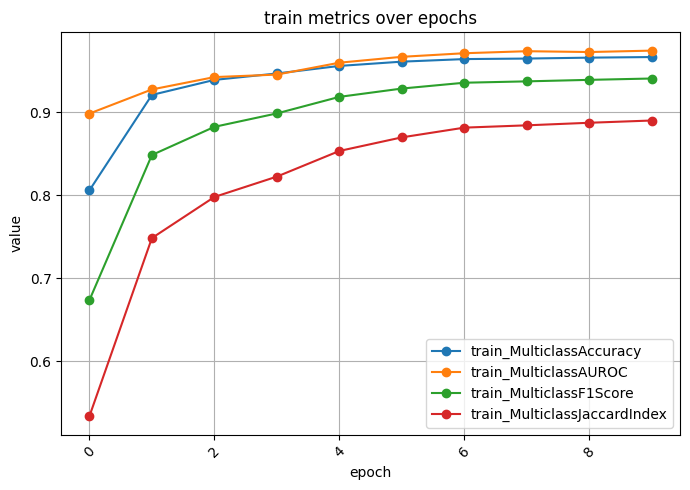

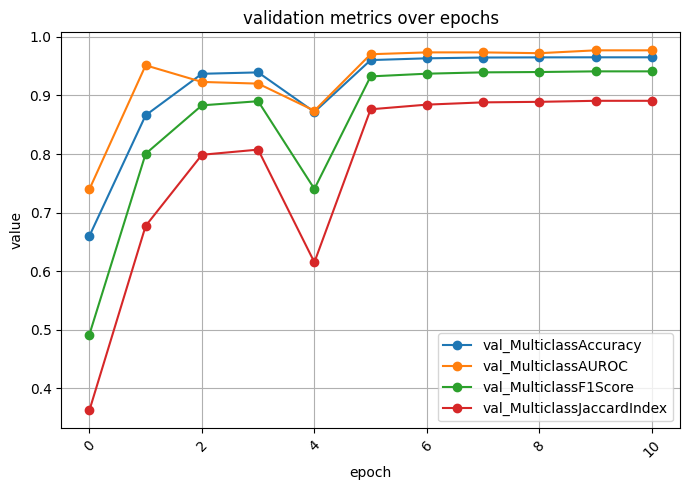

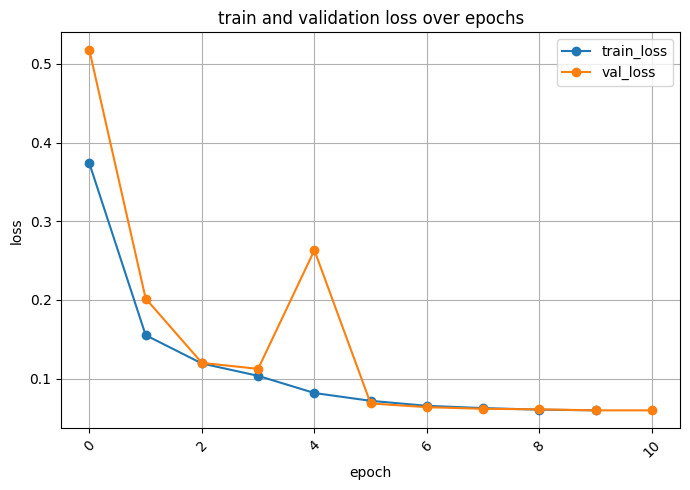

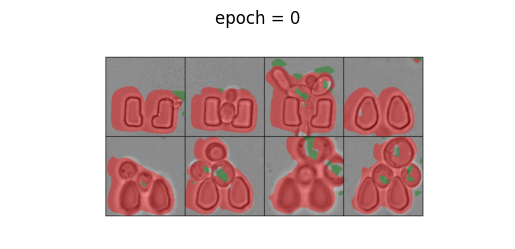

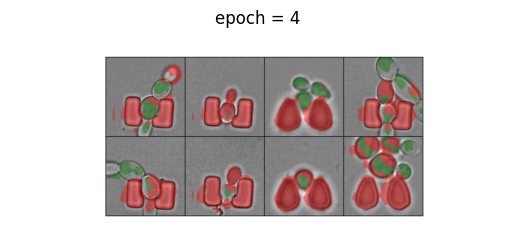

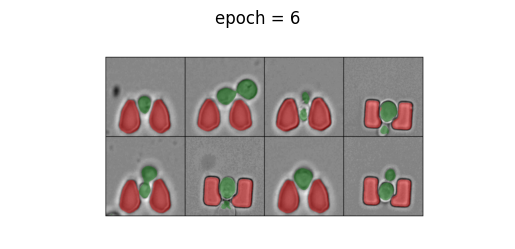

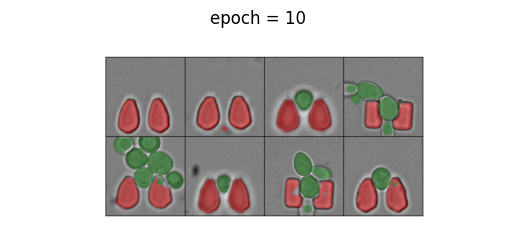

In [24]:
graph('model_logs_task3_2/version_0/metrics.csv')
epoch_pics(callback)

### Задание 4 (3 балла). Модификация архитектуры

Ваша задача - извлечь максимальную точность из модели, в которой будет не более 50k параметров. Для этого внесите правки в архитектуру модели.

В частности, попробуйте заменить в блоке `Down` комбинацию conv+maxpool на dilated conv (`nn.Conv2d(..., dilation=2)`). В остальном - полная свобода творчества, можете перерабатывать архитектуру как угодно.

Как обычно, запустите эксперимент (или несколько) с выводом всех графиков и картинок.

In [26]:
datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=4,
)

In [27]:
class Down_new(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.dilated_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=2)

    def forward(self, x: Tensor) -> Tensor:
        return self.dilated_conv(x)

In [28]:
class UNet_new(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down_new(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        # создаём список для хранения промежуточных активаций
        xs = []
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits

In [31]:
callback = VisualizationCallback(pictures_dir='epoch_pics_task4')
model = UNet_new(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64], bilinear=True)
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=13,
    limit_train_batches=None,
    limit_val_batches=None,
    logger=CSVLogger(save_dir=".", name="model_logs_task4", version=0),
    callbacks=[callback]
)
lit_module = Lit(
    model=model,
    learning_rate=0.01,
    loss_func=loss_weights
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

trainer.validate(model=lit_module, dataloaders=datamodule.val_dataloader())

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet_new         | 46.6 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
46.6 K    Trainable params
0         Non-trainable params
46.6 K    Total params
0.186     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=13` reached.
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_MulticlassAUROC     │     0.9375834465026855     │
│   val_MulticlassAccuracy   │     0.8637913465499878     │
│   val_MulticlassF1Score    │     0.7222177982330322     │
│ val_MulticlassJaccardIndex │     0.5950419902801514     │
│          val_loss          │    0.38016217947006226     │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.38016217947006226,
  'val_MulticlassAccuracy': 0.8637913465499878,
  'val_MulticlassAUROC': 0.9375834465026855,
  'val_MulticlassF1Score': 0.7222177982330322,
  'val_MulticlassJaccardIndex': 0.5950419902801514}]

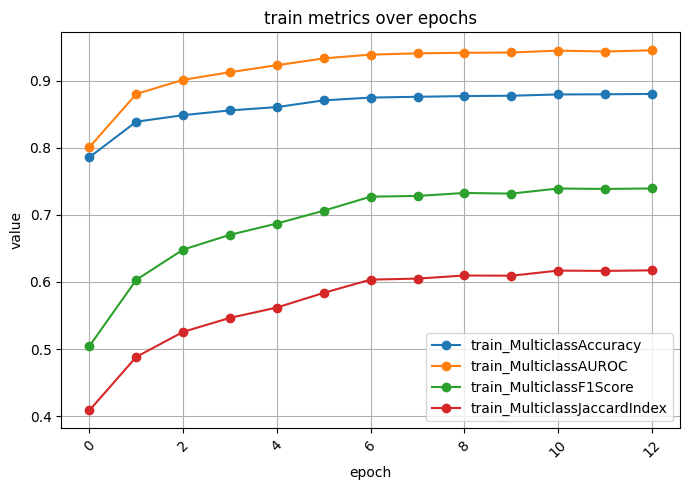

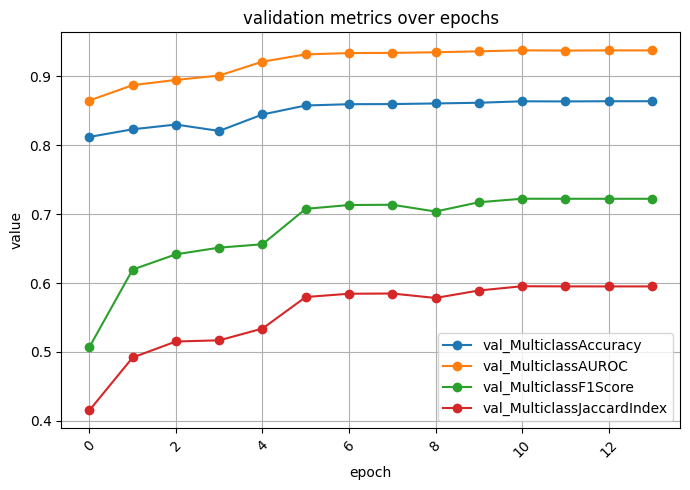

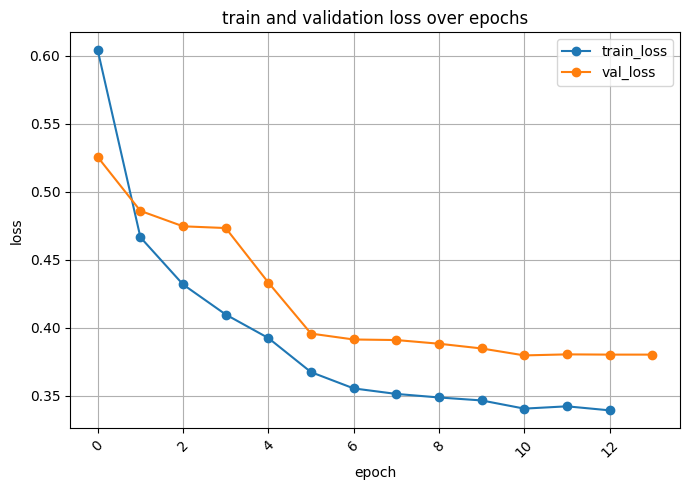

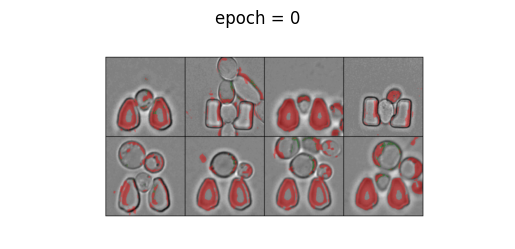

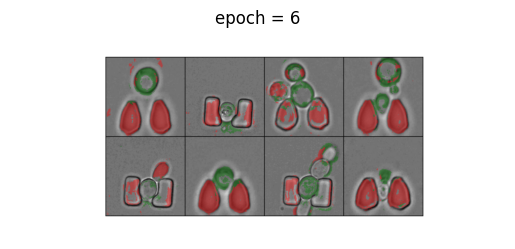

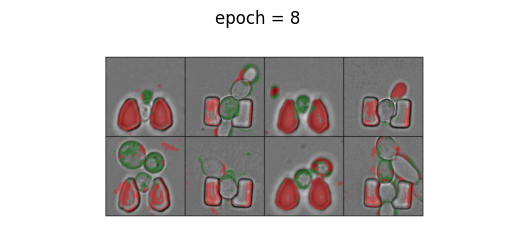

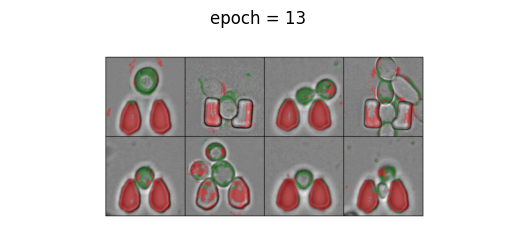

In [32]:
graph('model_logs_task4/version_0/metrics.csv')
epoch_pics(callback)